In [1]:
import numpy as np
import pandas as pd
#import scipy as sci
#import sympy as sym
#import statistics as stat
import random as rng
#import itertools as ite
#import time
#import math
#------------------
import matplotlib.pyplot as plt
#import matplotlib.animation as manim
import matplotlib_inline
#from matplotlib.ticker import AutoMinorLocator
#import cartopy.crs as ccrs
#from cartopy.io.img_tiles import GoogleTiles
#import timeit
#from IPython.display import display
from mpl_toolkits import mplot3d
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator 

#---------
#import json
#import os
#import gc
#import sys
#----------
#import awkward as ak
#import uproot
#import vector

#Files, for_Thomas/DlKKs_ccMC_df.p      for_Thomas/DlKKs_chgMC_df.p     for_Thomas/DlKKs_data_df.p        for_Thomas/DlKKs_mixMC_df.p

#I guess that means you have access to the dataframes – let me know if you have questions as you start to explore the contents.  
#Once you’re ready to start doing some calculations I suggest you create new dataframe columns where you combine the pi1_ and pi2_ momentum variables 
#(i.e. ECM, pCM, InvM, CosTheta, Phi) to create “pi1pi2_” variables, and compare these with the K0S_ variables that are already stored.
pd.options.display.max_columns = None
'''To see the impact of detector resolution, look at the D0 invariant mass (SLD0_InvM, if I remember correctly) and plot it for different decayModeIDs. 

#D0SL_InvM

#D0SL_decayModeID	

Also develop a def function to plot the different sources (ccbar, aka “cc”, B0B0bar, aka “mix”, B+B-, aka “chg”) as stacked histograms 
(so you can see how the total number of entries is composed of the subcomponents). 

 

Then plot the data with error bars (plt.errorbar) where the error bars are given by Poisson statistics, i.e.
the error bar is the sqrt of the number of entries in a bin.  
For the dataframes I gave you, we have 4 times as much MC as we have data, 
so you need to weight the MC by 0.25 if you want to plot the data and MC on the same plot (which is the aim).

 

Investigate different variables (*_ROE, *_chiProb, BSL_cosBY, K0S_InvM, eSL_pCM, D0SL_pCM) 
#Rest of event, X^2 probability of fit or vertex/track probability fit. Neutral K short invariant mass, Electron short, center momentum, same for neutral d
# 
to see how you might preferentially select BBbar decays, and how you might preferentially select B+B- over B0B0bar.
BSL semileptonic (weak interaction, involved with production of lepton and leptons anti neut). to cos angle between B and missing momentum




 

Investigate the number of candidates (__ncandidates__) and see how, when __ncandidates__>1, 
the individual candidates in the same __event__ differ from each other (this you can’t really do with plots; you can inspect the df values). 

Eventually we need to represent each event with equal weight, meaning either choose a single candidate per event or weight each candidate by 1 / __ncandidates__.'''

df_ccmc = pd.read_pickle('for_Thomas/DlKKs_ccMC_df.p')
df_chgmc = pd.read_pickle('for_Thomas/DlKKs_chgMC_df.p')
df_mixmc = pd.read_pickle('for_Thomas/DlKKs_mixMC_df.p')
df_data = pd.read_pickle('for_Thomas/DlKKs_data_df.p')
datas = [df_ccmc,df_chgmc,df_mixmc,df_data]
df_names = ['ccbar','B0B0bar','B+B-']

data_counts__data_id = [3964, 741, 6924, 17462, 5752, 1348] #So we have 

mc_counts_src_id = [
    [2532, 624, 5187, 16809, 3998, 1719],
    [8154, 1360, 12447, 30526, 8115, 1818],
    [2356, 397, 5362, 10230, 5306, 759]
]
my_weights = np.array([3.290111, 3.21322537, 3.32120162, 3.29658687, 3.02833797, 3.18694362])**(-1) #Total data in each decay ID/Total combined Source

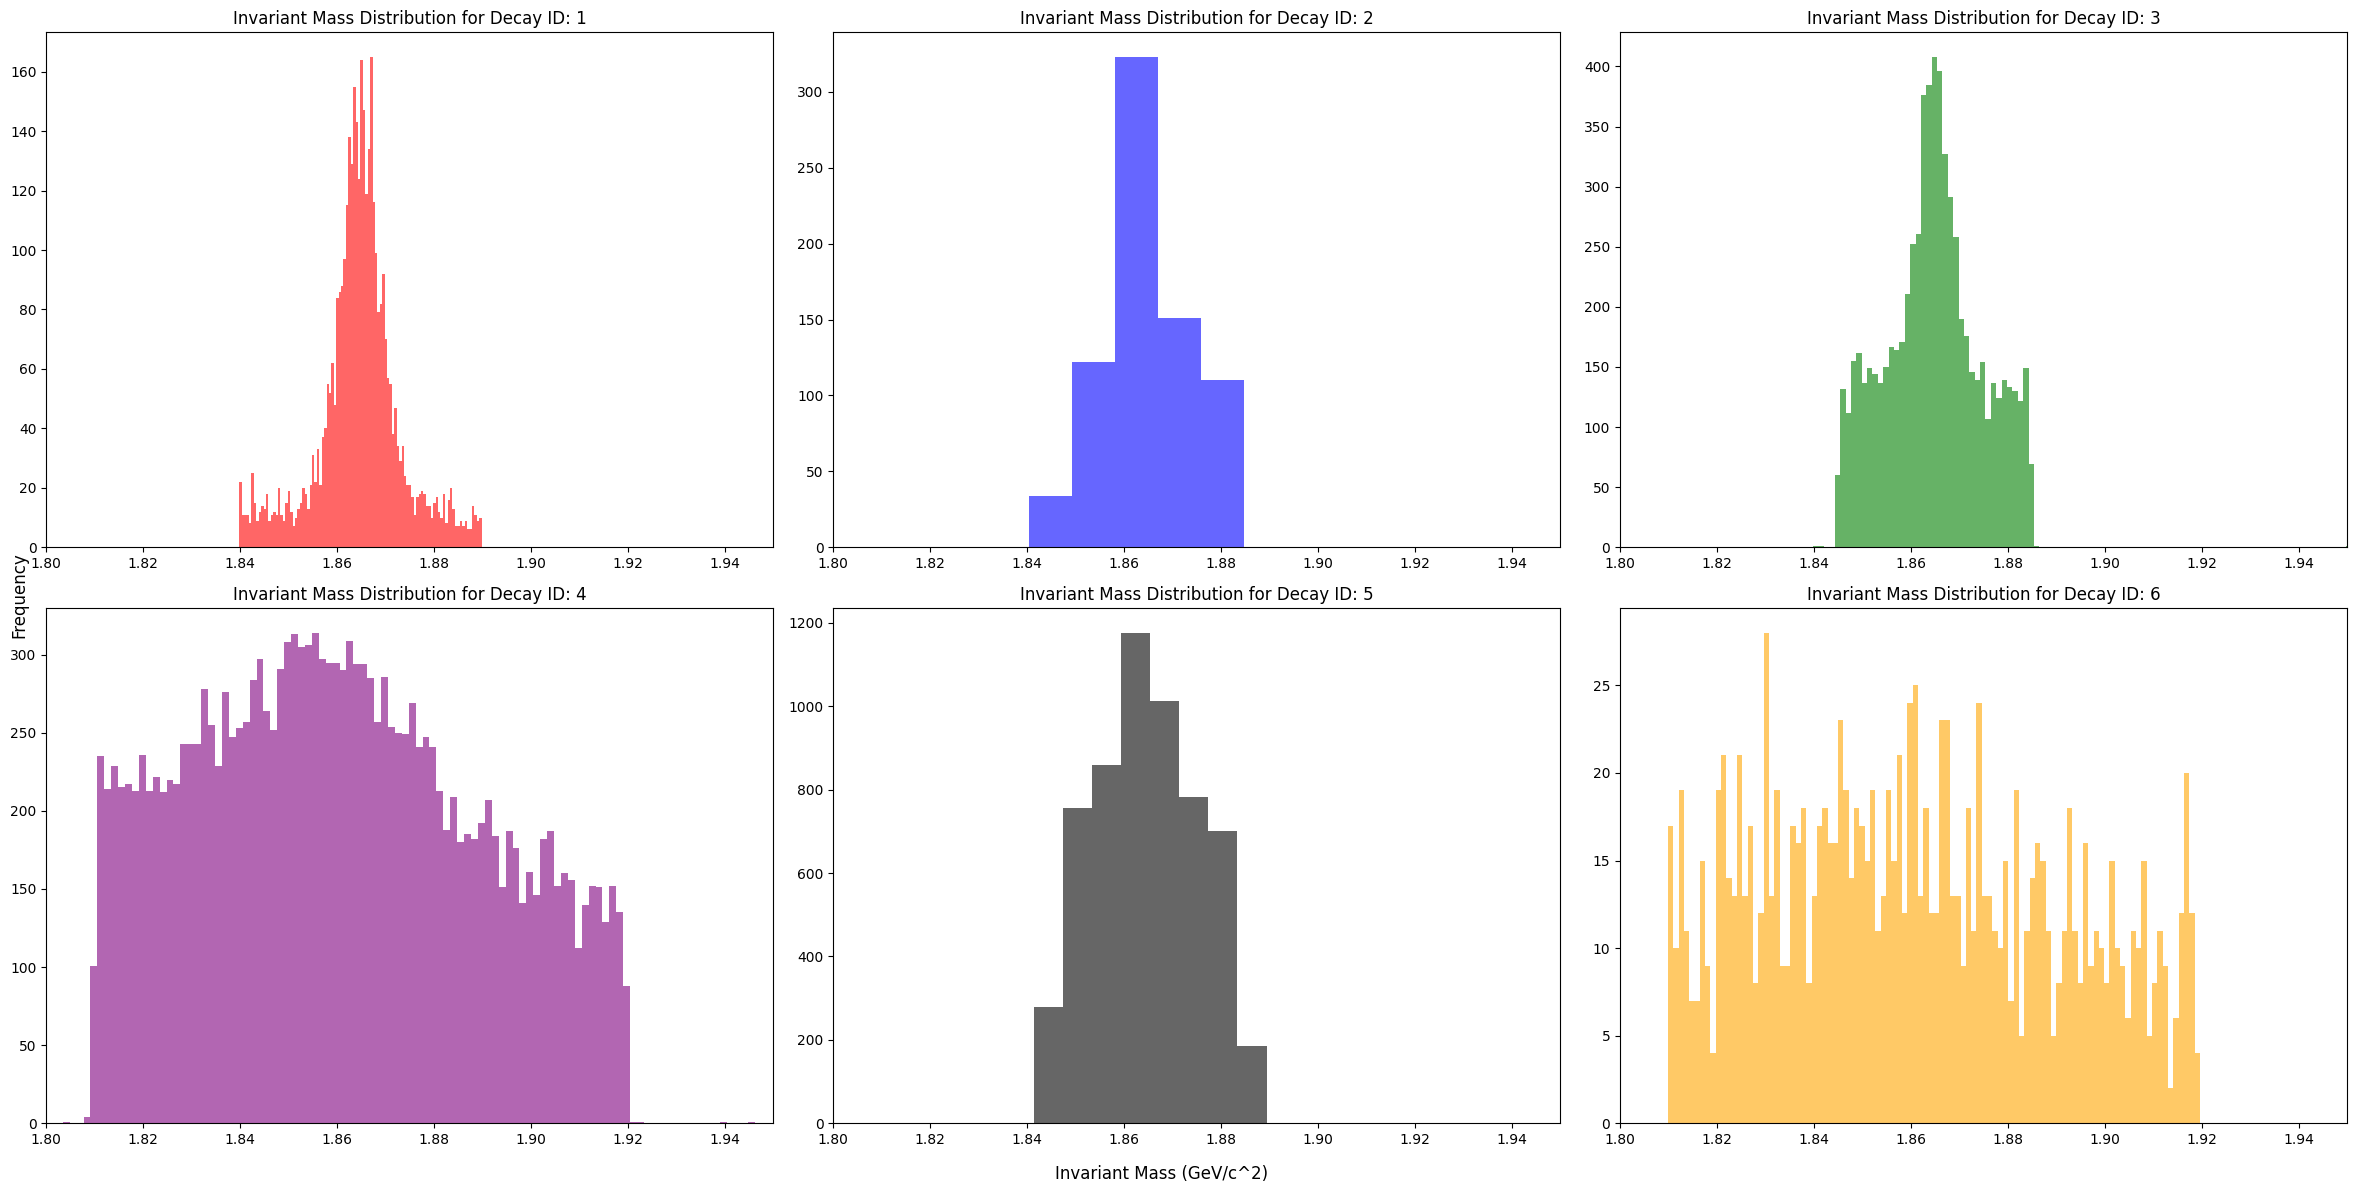

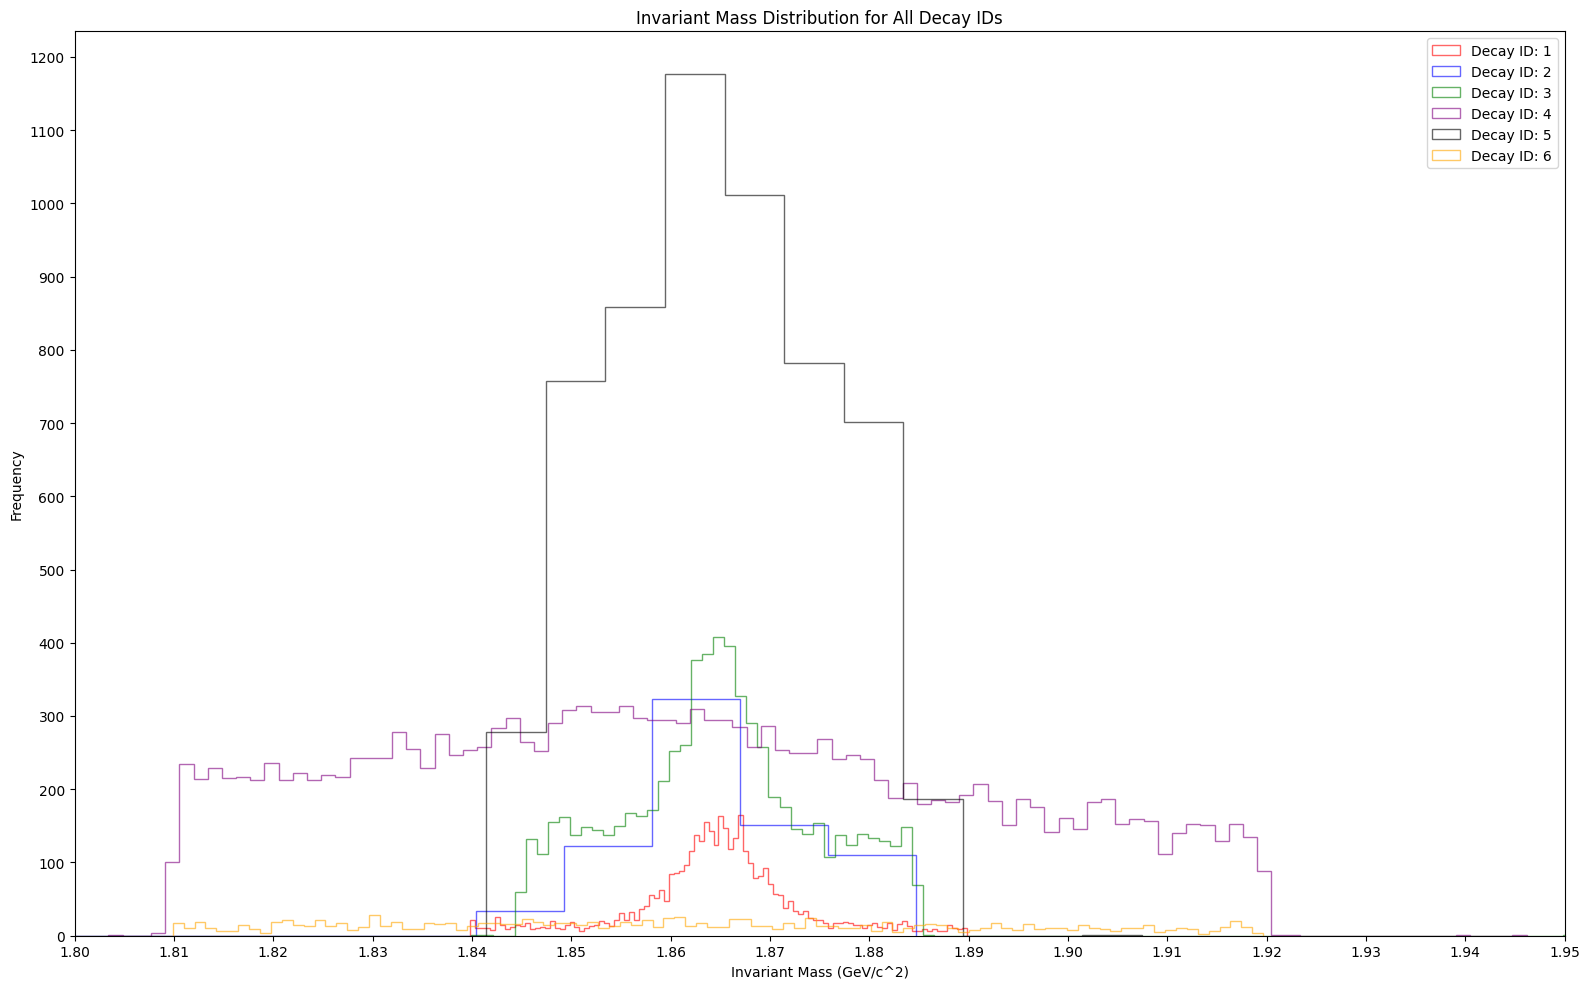

In [2]:
#Part one:
#Note, all default units from documentation are ns, cm, rad, GeV
max_id = int(max(df_data.loc[:,'D0SL_decayModeID']))
min_id = int(min(df_data.loc[:,'D0SL_decayModeID']))



fig, axs = plt.subplots(max_id//3,max_id//2, figsize=(24,12))  #Keep general (but terrible idea if lots of IDs visual wise)
axs = axs.flatten() #Fix for increments
colors = ['red','blue','green','purple','black','orange']
labels = ['Decay ID: 1', 'Decay ID: 2', 'Decay ID: 3', 'Decay ID: 4', 'Decay ID: 5', 'Decay ID: 6']
fig.supxlabel('Invariant Mass (GeV/c^2)')
fig.supylabel('Frequency') #Maybe add per plot rather than supreme? #Perhaps adjust title spacing
for i in range(min_id, max_id + 1):
    index = i - min_id
    axs[index].hist(df_data.query(f'D0SL_decayModeID == {i}')['D0SL_InvM'], bins=100, color=colors[index], alpha=0.6)
    axs[index].set_title(f'Invariant Mass Distribution for Decay ID: {i}')
    axs[index].set_xlim(1.8, 1.95)

plt.tight_layout()

plt.figure(figsize=(16, 10))
for i in range(min_id, max_id + 1):
    index = i - min_id
    plt.hist(df_data.query(f'D0SL_decayModeID == {i}')['D0SL_InvM'], bins=100, color=colors[index], alpha=0.6, histtype='step', label=labels[index]) #Perhaps display total counts with label for each
plt.title('Invariant Mass Distribution for All Decay IDs')
plt.xlim(1.8, 1.95)
plt.locator_params(axis='x', nbins=15)
plt.locator_params(axis='y', nbins=15) #Let me know if too many tickers.
plt.xlabel('Invariant Mass (GeV/c^2)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.legend()
plt.show()

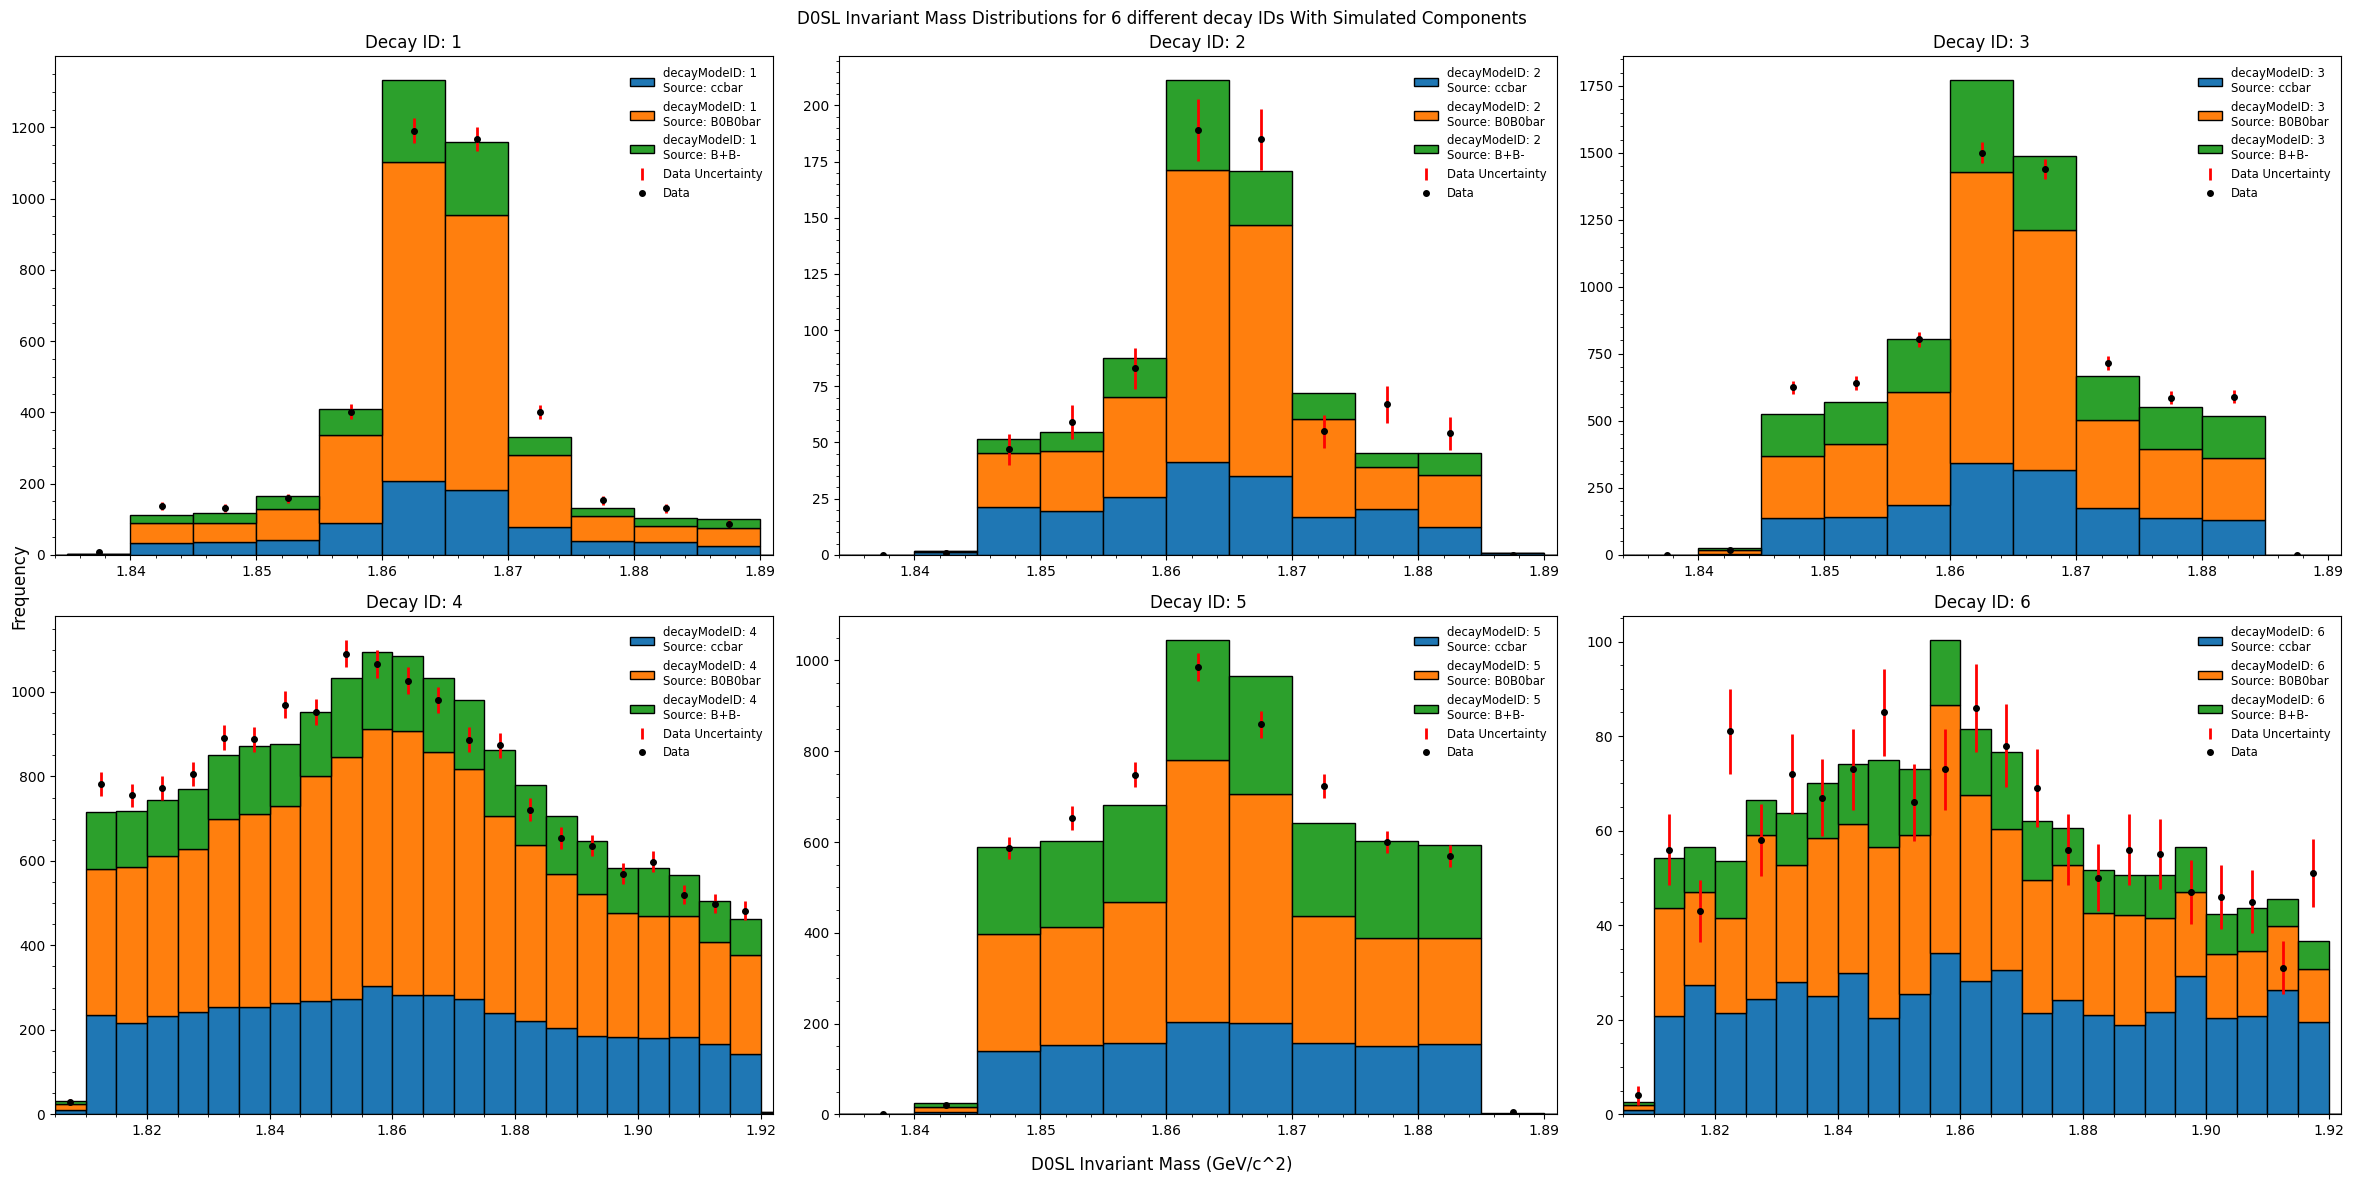

In [3]:
# I think the step plot with them all together works well for showing really cluttered data, so I thought I'd showcase.
#Part 2
weight = 0.25 
my_weights = np.array([3.290111, 3.21322537, 3.32120162, 3.29658687, 3.02833797, 3.18694362])**(-1) #Total data in each decay ID/Total combined count of source Data for decay ID

def plot_sim(datas, particle, quantity, d_id, src_names, bin_c=100, ax=None, src_count=3, scale_weight=1.0, bin_edges=None, err=False, filtarg = 'decayModeID'): 
    '''
    Args
    -> datas, list of data
    -> particle, name as a string, ie (D0SL)
    -> quantity, as a string, ie (InvM)
    -> d_id, filtering id, integer
    -> src_names, list of decay source names (in order of data list)
    -> bin_c, bin number
    -> ax, axis of subplot none by default for a single plot. axs[i] object otherwise
    -> src_count, count of sources to plot, 3 default
    -> scale_weight, normalization for all MC samples combined for decay ID and every entry
    -> bin_edges, for custom fitting
    -> err, for including attempt at source uncertainty
    -> filtarg, sorting filter or column (please use only ones that take whole numbers), decayModeID by default
    Future iterations will reduce parameter needs, improve the filtering and collecting algorithm, adjust layouts, and add more functionality
    '''
    phdl = particle+'_'+quantity
    
    data_list = []
    weight_list = []
    label_list = []
    
    for i in range(src_count):
        try:
            data = datas[i].query(f'{particle}_{filtarg}=={d_id}')[phdl] #Filter to quantities on filtering arg
        except:
            data = datas[i].query(f'{filtarg}=={d_id}')[phdl] #Yes, this is the laziest fix in the world for ncandidates

        data_list.append(data) #Grab all filtered ID data of interest via the loop
        weight_list.append(np.full(len(data),scale_weight)) #To prevent issues with non uniformity
        label_list.append(f'{filtarg}: {d_id}\nSource: {src_names[i]}') #Grab labels
    
    if ax is not None and not err:
        ax.hist(data_list, bins=bin_edges, stacked=True,weights=weight_list,label=label_list,edgecolor='black',align='mid')  
    elif ax is not None:
        ax.hist(data_list, bins=bin_edges, stacked=True,weights=weight_list,label=label_list,edgecolor='black')
        counts, edges, __ = ax.hist(data_list, bins=bin_edges, stacked=False, weights=weight_list, alpha=0)
        top_y_values = np.sum(counts, axis=0)
        centers = 0.5 * (edges[:-1] + edges[1:])
        step_size = bin_edges[1] - bin_edges[0]
        errors = np.sqrt(top_y_values)
        ax.bar(centers,height=2*errors,bottom=top_y_values - errors,alpha=0.8, #This was a pain to get working, have to draw invisible histogram to avoid the stacking
            color='none',edgecolor='black',hatch='////',width=step_size,label='Sim Uncertainty')
    else:
        plt.hist(data_list, bins=bin_edges,stacked=True,weights=weight_list,label=label_list,edgecolor='black')
        
        
filtarg='decayModeID'
fig, axs = plt.subplots(max_id//3, max_id//2, figsize=(24,12))  #Keep general (but terrible idea if lots of IDs visual wise)
axs = axs.flatten() #Fix for increments
colors = ['red','blue','green','purple','black','orange']
labels = ['Decay ID: 1', 'Decay ID: 2', 'Decay ID: 3', 'Decay ID: 4', 'Decay ID: 5', 'Decay ID: 6'] 
particle = 'D0SL'
quantity = 'InvM'
pdhl = particle+'_'+quantity
bin_c = 30
inv_mass_range = (1.8, 1.95) #Fixing range
edges = np.linspace(*inv_mass_range, bin_c + 1)
fig.supxlabel(f'{particle} Invariant Mass (GeV/c^2)')
fig.supylabel('Frequency') #Maybe add per plot rather than supreme? #Perhaps adjust title spacing
for i in range(min_id, max_id + 1):
    index = i - min_id
    counts, _ = np.histogram(df_data.query(f'{particle}_{filtarg} == {i}')[pdhl], bins=edges)
    data_err = np.sqrt(counts)
    centers = 0.5*(edges[:-1]+edges[1:])
    axs[index].errorbar(centers,counts,yerr=data_err,fmt='none',ecolor='red',linewidth=2, label='Data Uncertainty')
    axs[index].errorbar(centers,counts,yerr=None,fmt='ko',label='Data',markersize=4,linewidth=2)
    axs[index].set_title(f'Decay ID: {i}')
    if i in [1, 2, 3, 5]:
        axs[index].set_xlim(1.834, 1.891) #"""I really want to make a function or automatic method to do this but its tricky to find a good way to estimate x limits, maybe IQR would work"""
        ticks = np.arange(1.834, 1.891 + 0.001, 0.0057)
    elif i in [4, 6]:
        axs[index].set_xlim(1.805, 1.922)
        ticks = np.arange(1.805, 1.922 + 0.001, 0.0117)
    plot_sim(datas, particle, quantity, i, df_names, bin_c=bin_c, ax=axs[index], scale_weight=my_weights[index], bin_edges=edges, err=False, filtarg=filtarg)
    '''I chose to do my_weights[index] instead of 0.25 as stated for the weight, so that for each decay ID, MC total counts matched the datas total counts
    Otherwise it seemed there was not enough mc contribution to match against the data, but this could be wrong thinking'''
    axs[index].legend(fontsize='small',frameon=False)
    axs[index].xaxis.set_minor_locator(AutoMinorLocator())
    axs[index].yaxis.set_minor_locator(AutoMinorLocator())
    #axs[index].set_xticks(ticks) Made it kinda too messy for double ticks
fig.suptitle(f'{particle} Invariant Mass Distributions for {max_id} different decay IDs With Simulated Components')
plt.tight_layout()


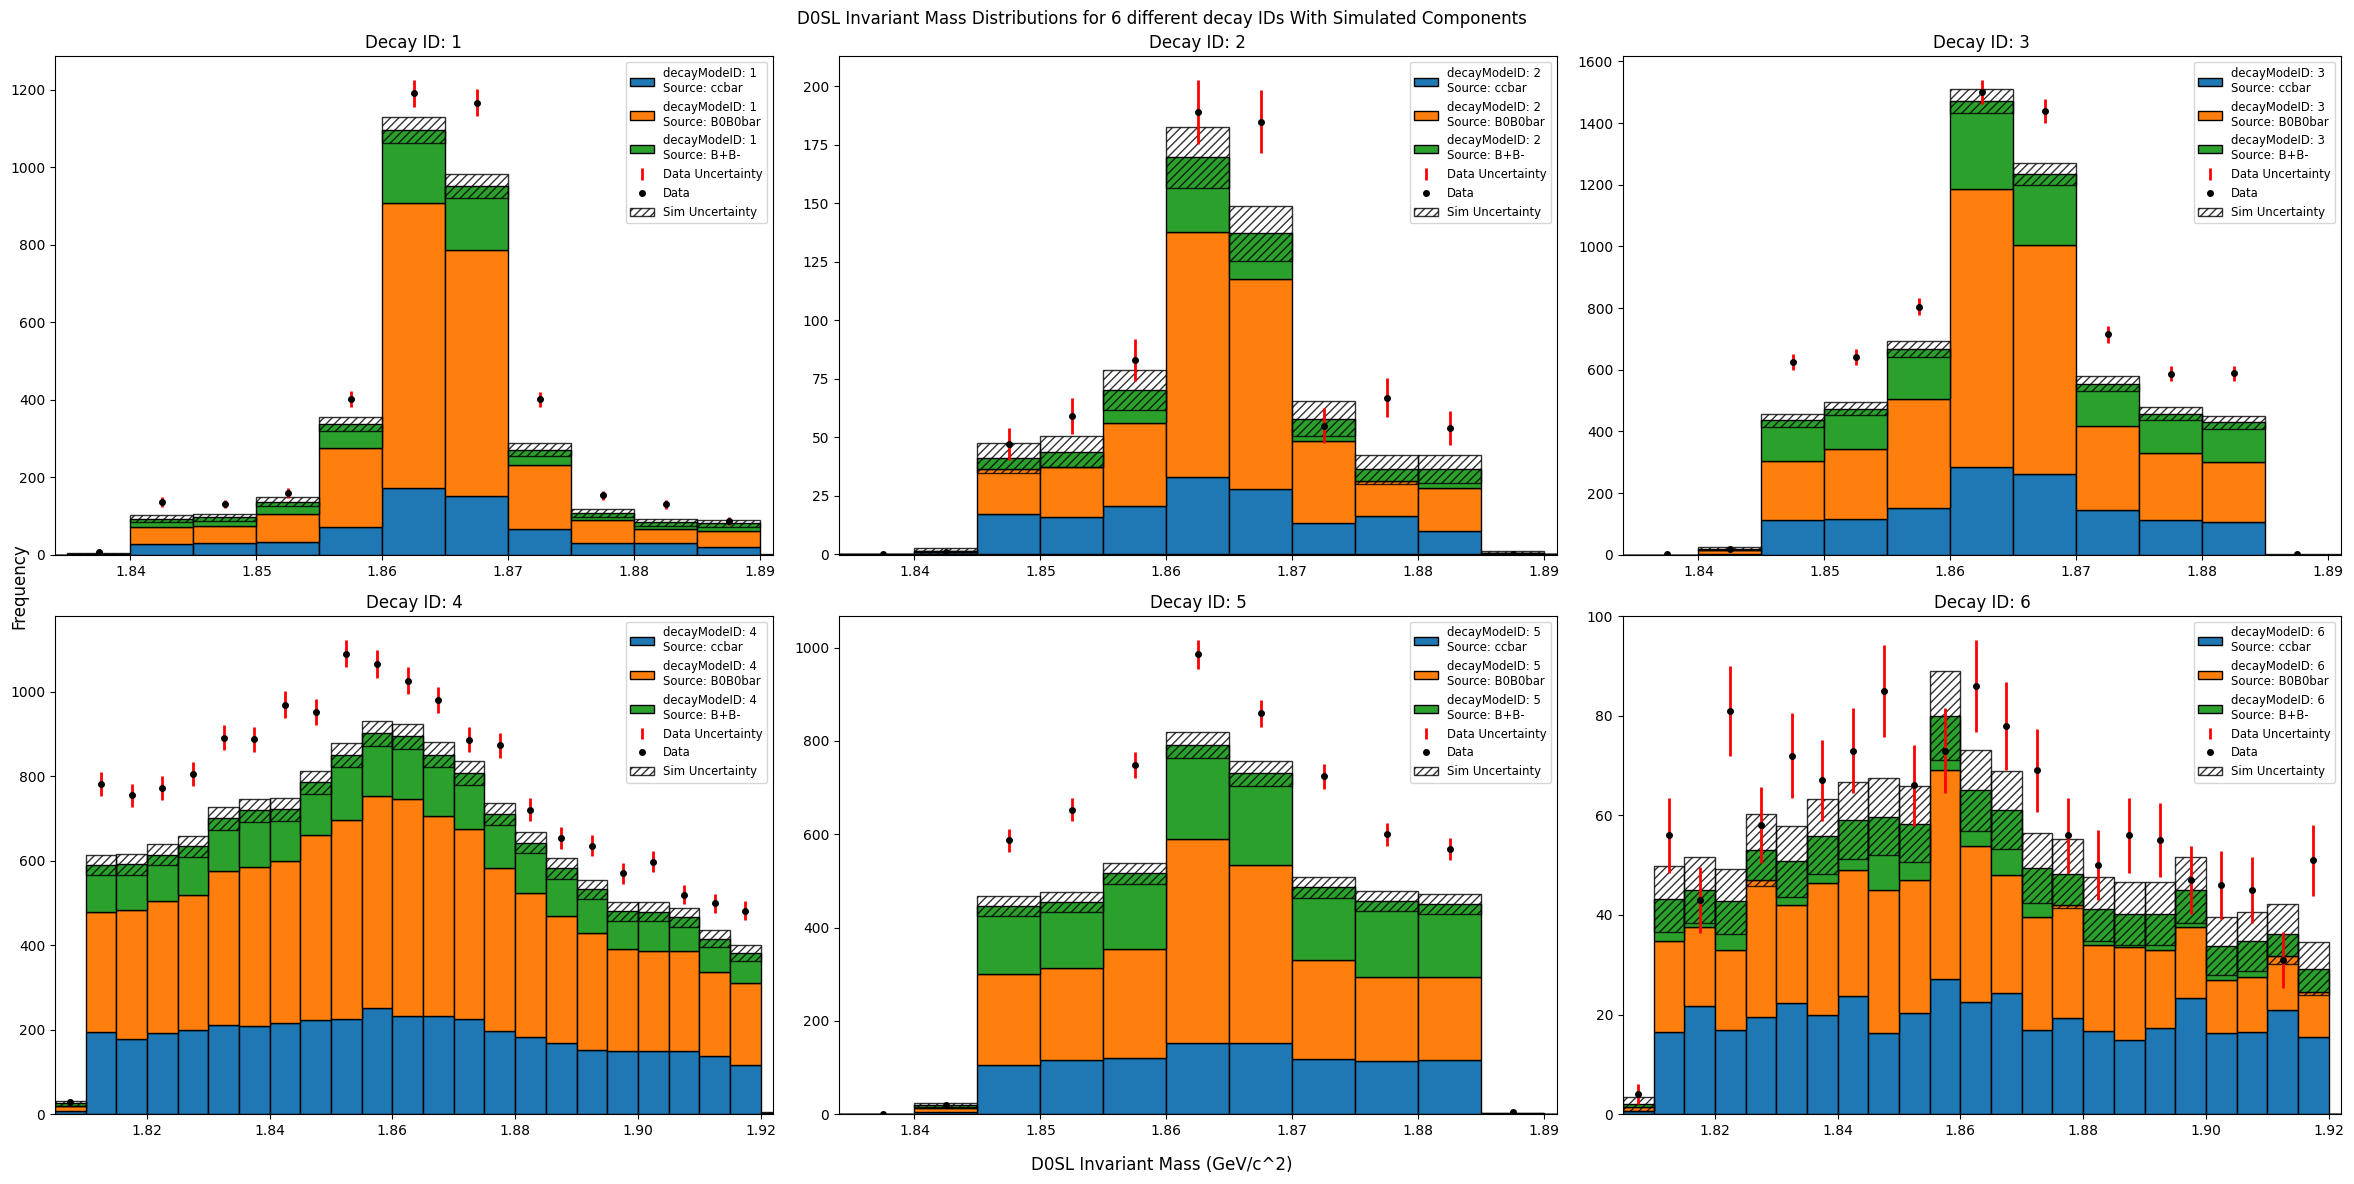

In [4]:
#Here are the ones using a 0.25 weight for just everything, as such. I've thus added an error to the total count for each bin, although I'm not certain this is statistically defensible


fig2, axs2 = plt.subplots(max_id//3, max_id//2, figsize=(24,12))  #Keep general (but terrible idea if lots of IDs visual wise)
axs2 = axs2.flatten() #Fix for increments
fig2.supxlabel(f'{particle} Invariant Mass (GeV/c^2)')
fig2.supylabel('Frequency') #Maybe add per plot rather than supreme? #Perhaps adjust title spacing
for i in range(min_id, max_id + 1):
    index = i - min_id
    counts, _ = np.histogram(df_data.query(f'{particle}_{filtarg} == {i}')[pdhl], bins=edges)
    data_err = np.sqrt(counts)
    centers = 0.5*(edges[:-1]+edges[1:])
    axs2[index].errorbar(centers,counts,yerr=data_err,fmt='none',ecolor='red',linewidth=2, label='Data Uncertainty')
    axs2[index].errorbar(centers,counts,yerr=None,fmt='ko',label='Data',markersize=4,linewidth=2)
    axs2[index].set_title(f'Decay ID: {i}')
    if i in [1, 2, 3, 5]:
        axs2[index].set_xlim(1.834, 1.891) #"""I really want to make a function or automatic method to do this but its tricky to find a good way to estimate x limits, maybe IQR would work"""
        ticks = np.arange(1.834, 1.891 + 0.001, 0.0057)
    elif i in [4, 6]:
        axs2[index].set_xlim(1.805, 1.922)
        ticks = np.arange(1.805, 1.922 + 0.001, 0.0117)
    plot_sim(datas, particle, quantity, i, df_names, bin_c=bin_c, ax=axs2[index], scale_weight=0.25, bin_edges=edges, err=True,filtarg=filtarg)
    '''I chose to do my_weights[index] instead of 0.25 as stated for the weight, so that for each decay ID, MC total counts matched the datas total counts
    Otherwise it seemed there was not enough mc contribution to match against the data, but this could be wrong thinking'''
    axs2[index].legend(fontsize='small')
    #axs[index].set_xticks(ticks) Made it kinda too messy for double ticks
fig2.suptitle(f'{particle} Invariant Mass Distributions for {max_id} different decay IDs With Simulated Components')
plt.tight_layout()


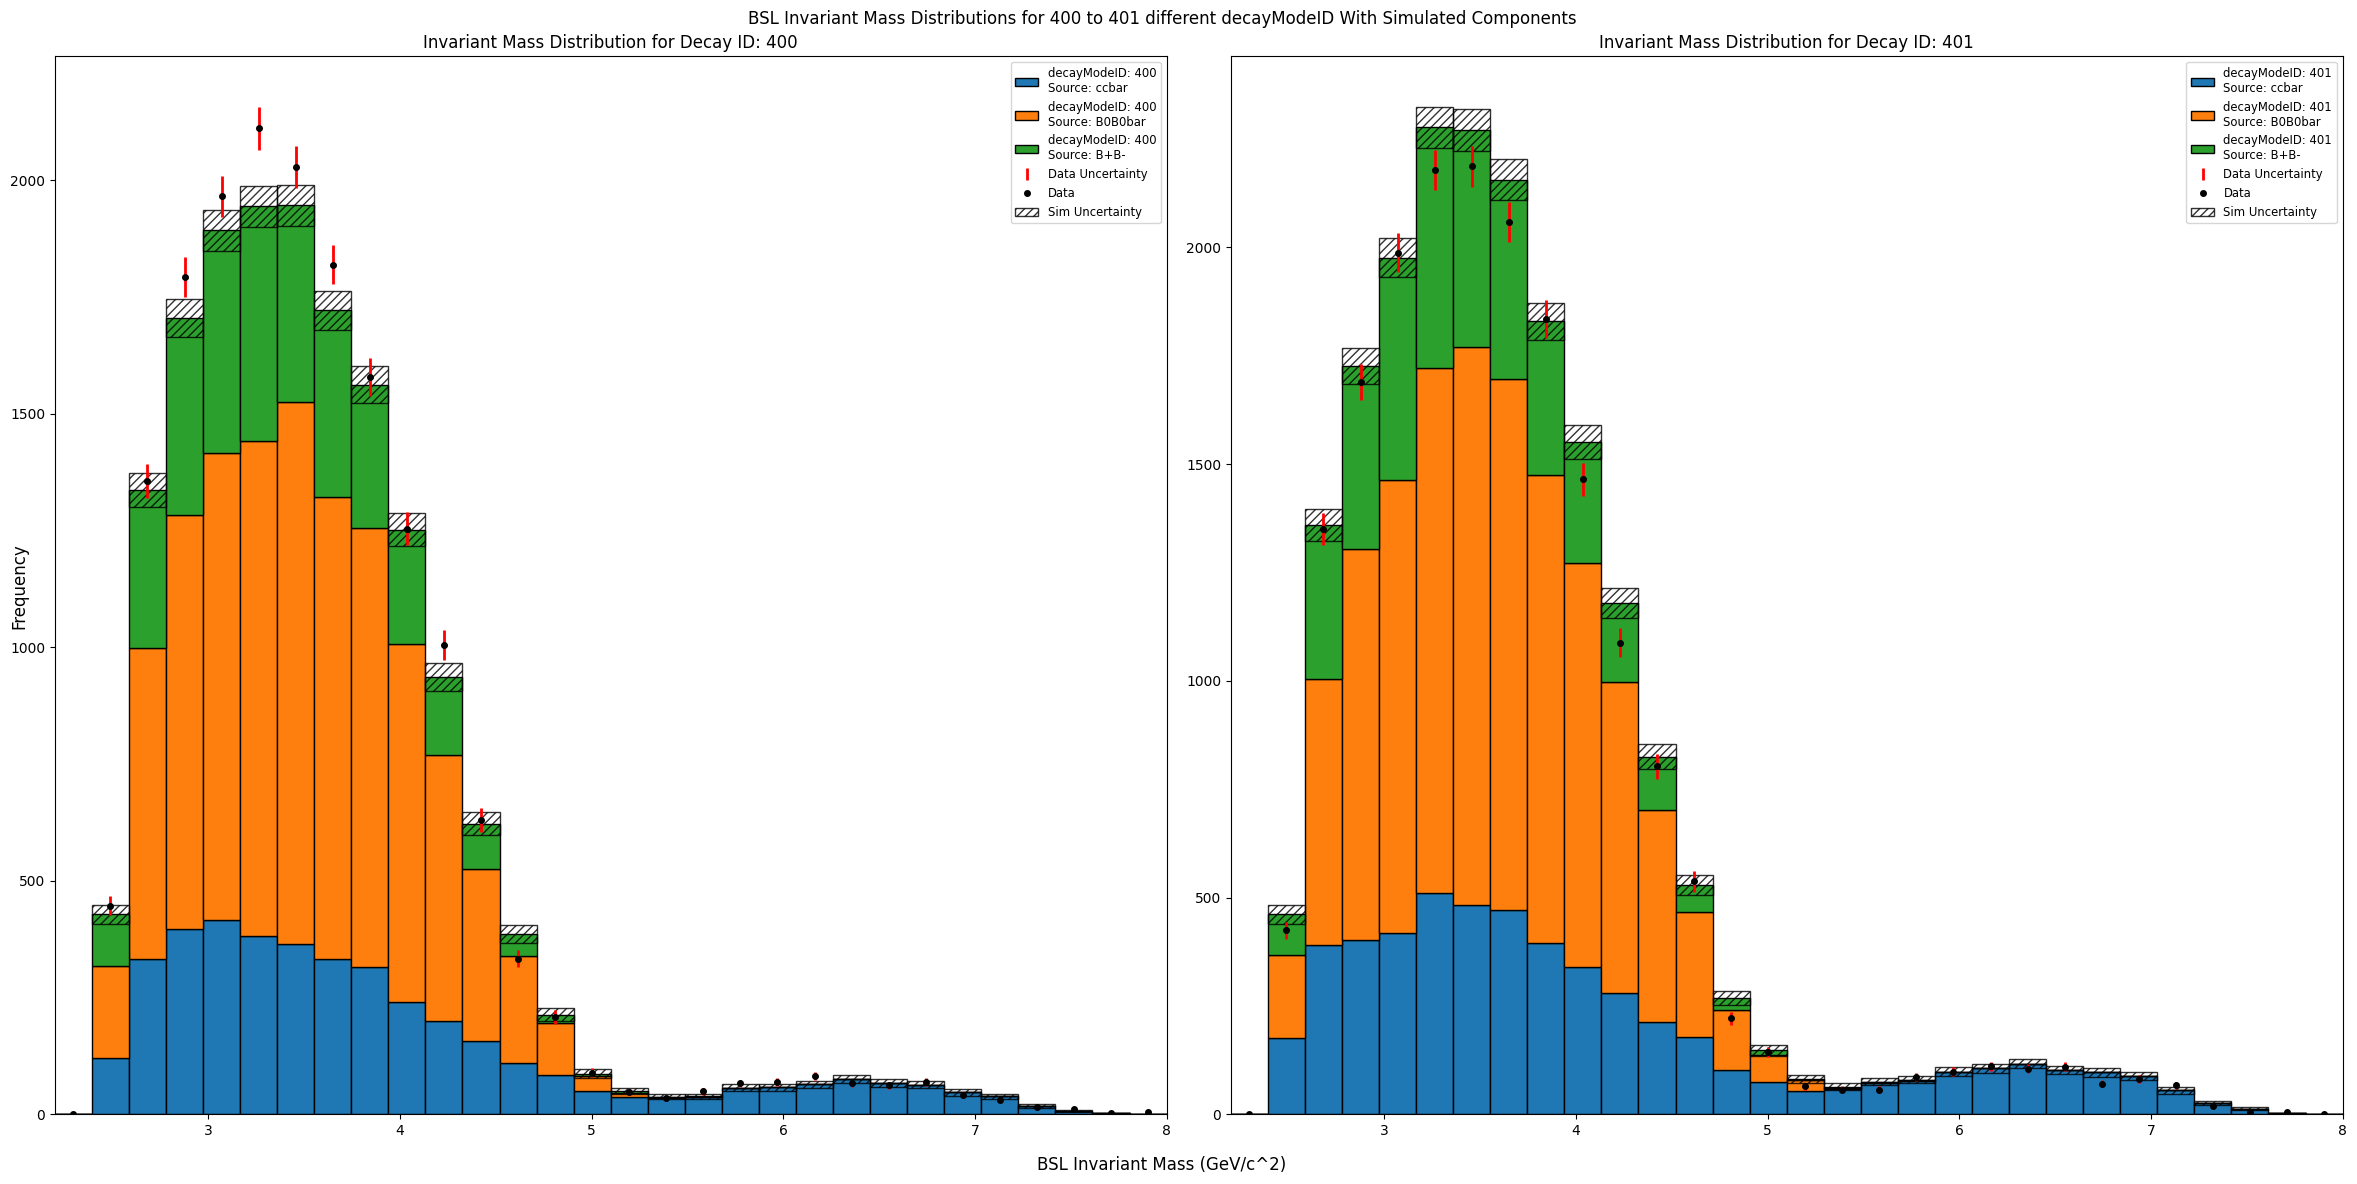

In [5]:
#At first glance, my interpretation is that in effectively all cases, B0B0Bar, ie, mix, dominate in contributions to the total decay, most of the invariant mass occurs between 1.86 and 1.87 GeV/C^2. And the shape of the data distribution is consistent with the shape of the simulation distribution
#Except for some strange discrepencies in plot 6
#To test my codes generality, I'm now plotting BSL Inv Mass distributions
max_id3 = int(max(df_data.loc[:,'BSL_decayModeID']))
min_id3 = int(min(df_data.loc[:,'BSL_decayModeID']))
#400 and 401


fig3, axs3 = plt.subplots(1, 2, figsize=(24,12))  #Keep general (but terrible idea if lots of IDs visual wise) '''Wow it broke for this one already, knew it was a bad method'''
axs3 = axs3.flatten() #Fix for increments
colors = ['purple','green','pink','orange','brown','cyan']
labels = ['Decay ID: 1', 'Decay ID: 2', 'Decay ID: 3', 'Decay ID: 4', 'Decay ID: 5', 'Decay ID: 6'] 
particle = 'BSL'
quantity = 'InvM'
phdl = particle+'_'+quantity
fig3.supxlabel(f'{particle} Invariant Mass (GeV/c^2)')
fig3.supylabel('Frequency') #Maybe add per plot rather than supreme? #Perhaps adjust title spacing
bin_c3 = 30
inv_mass_range3 = (2.2, 8) #Fixing range
edges3 = np.linspace(*inv_mass_range3, bin_c3 + 1)
phdl3 = particle+'_'+quantity
for i in range(min_id3, max_id3 + 1):
    index = i - min_id3
    counts, _ = np.histogram(df_data.query(f'{particle}_{filtarg} == {i}')[phdl3], bins=edges3)
    data_err = np.sqrt(counts)
    centers = 0.5*(edges3[:-1]+edges3[1:])
    axs3[index].errorbar(centers,counts,yerr=data_err,fmt='none',ecolor='red',linewidth=2, label='Data Uncertainty')
    axs3[index].errorbar(centers,counts,yerr=None,fmt='ko',label='Data',markersize=4,linewidth=2)
    axs3[index].set_title(f'Invariant Mass Distribution for Decay ID: {i}')
    axs3[index].set_xlim(2.2,8)
    plot_sim(datas, particle, quantity, i, df_names, bin_c=bin_c3, ax=axs3[index], scale_weight=my_weights[index], bin_edges=edges3,err = True,filtarg=filtarg)
    axs3[index].legend(fontsize='small')
    #axs3[index].set_xticks(ticks) Made it kinda too messy for double ticks
fig3.suptitle(f'{particle} Invariant Mass Distributions for {min_id3} to {max_id3} different {filtarg} With Simulated Components')
plt.tight_layout()

#Honestly, only minor changes were required, but it showed me what needed to change to better improve the generality in the first plots
#Whats interesting is this distribution more matches a poisson distribution of a right skewed antisymmetric plot. The shape of the data and MC are the same, and a gain the mixed decay is contribbuting the most as expected from above


In [6]:
#To test my codes generality, I'm now plotting K0S ECM filtering on K0S_isSignalAcceptMissing, ----A future idea for plot sim is to include multiple sorting parameters, with and,or restrictions.

'''Note: I'm not even sure if plotting this makes sense or is valuable whatsoever, it does not work well, I'm mostly trying to test my codes generality and what breaks it incase I want to use it for something similar later'''
# cntrl+ / to uncomment when its all highlighted


# max_id4 = int(max(df_data.loc[:,'__ncandidates__']))
# min_id4 = int(min(df_data.loc[:,'__ncandidates__'])) #Also make work for n_candidates
# #Boolean 'float'
# filtarg4 = '__ncandidates__'
# my_weights4 = np.array([3.290111, 3.21322537, 3.32120162, 3.29658687, 3.02833797, 3.18694362])**(-1) #Total data in each decay ID/Total combined Source
# fig4, axs4 = plt.subplots(7, 4, figsize=(24,12))  #Keep general (but terrible idea if lots of IDs visual wise) '''Wow it broke for this one already, knew it was a bad method'''
# axs4 = axs4.flatten() #Fix for increments
# #colors4 = ['cyan','pink','green','purple','brown','orange']
# labels = [f'{filtarg4} ID: 0', f'{filtarg4} ID: 1', f'{filtarg4} ID: 2', f'{filtarg4} ID: 3', f'{filtarg4} ID: 4'] #Also needed changed... Planning for a full function to encapsulate this type of stuff
# particle4 = 'K0S'
# quantity4 = 'ECM'
# phdl = particle4+'_'+quantity4
# fig4.supxlabel(f'{particle} Center of Mass Energy (GeV/c^2)') #Changed
# fig4.supylabel('Frequency') #Maybe add per plot rather than supreme? #Perhaps adjust title spacing
# bin_c4 = 30
# inv_mass_range4 = (0, 20) #Fixing range
# edges4 = np.linspace(*inv_mass_range4, bin_c4 + 1)
# phdl4 = particle4+'_'+quantity4 #this is fine for all particle quantities
# for i in range(min_id4, max_id4 + 1):
#     index = i - min_id4
#     counts, _ = np.histogram(df_data.query(f'{filtarg4} == {i}')[phdl4], bins=edges4) #changed for __ncandidates__
#     data_err = np.sqrt(counts)
#     mean = np.mean(counts)
#     range_width = 4
#     centers = 0.5*(edges4[:-1]+edges4[1:])
#     axs4[index].errorbar(centers,counts,yerr=data_err,fmt='none',ecolor='red',linewidth=2, label='Data Uncertainty')
#     axs4[index].errorbar(centers,counts,yerr=None,fmt='ko',label='Data',markersize=4,linewidth=2)
#     axs4[index].set_title(f'Center of Mass Energy Distributions for ID: {i}')
#     axs4[index].set_xlim(mean - range_width / 2, mean + range_width / 2)
#     plot_sim(datas, particle4, quantity4, i, df_names, bin_c=bin_c4, ax=axs4[index], scale_weight=0.25, bin_edges=edges4, filtarg=filtarg4)
#     axs4[index].legend(fontsize='small')
#     #axs4[index].set_xticks(ticks) Made it kinda too messy for double ticks
# fig4.suptitle(f'{particle4} Center of Mass Energy Distributions for {min_id4} to {max_id4} different {filtarg4} With Simulated Components')
# plt.tight_layout()



#Honestly, only minor changes were required, but it showed me what needed to change to better improve the generality in the first plots
#Whats interesting is this distribution more matches a poisson distribution of a right skewed antisymmetric plot. 
#The shape of the data and MC are the same, and a gain the mixed decay is contribbuting the most as expected from above


"Note: I'm not even sure if plotting this makes sense or is valuable whatsoever, it does not work well, I'm mostly trying to test my codes generality and what breaks it incase I want to use it for something similar later"